<h1>Training a fully connected neural network build from scratch</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utilities as utils           ## this module contains necessory items we will be using in this notebook

In [2]:
class myNN:
    """ This is my NN class which will define all the structure and funtionalities of my FCN. It has four methods :
        1. __init__   :  initialization of weights and biases
        2. forward    :  Perform forward pass of FCN
        3. loss       :  Calculate loss function after forward pass
        4. backward   :  Perform backward pass of FCN after loss calculation and calculate all the gradients of weights and biases
        5. update     :  Update the weights and biases of the FCN 
    """
    
    def __init__(self, layers):
        
        """ 
        args :::::     layer = [input_features, hidden layer1 , hidden layer2 , ......, outputs]
                    ie. number of nodes in each layer to define a fully connected neural network architechture
        
        """
        
        self.layers = layers
        self.weights, self.biases = utils.initialization(layers)     ## initialization of weights and biases in proper dimesnions
        self.forward_cache_list = []    ## this caches list will be used for saving the values during forward pass to
                                        ## reuse them during backward pass
        
        
    def forward(self, xdata):
        
        """ Performs forward pass for FCN of given architecture defined in __init__()
        
        args ::::       xdata is input matrix in shape of (D * m)
                            D = no. of input features
                            m = no. of training examples
        return ::::      aL  is the final output of softmax or sigmoid layer after forward pass
        """
        self.forward_cache_list = []   # some values which may be required during backpropogaation
        A = xdata                      # input data   ie. A0
        L = len(self.weights)          # L is total number of layers present in then FCNN
        
        for i in range(1, L):
            
            Aprev = A                  # output of previous layer after activation function
            #following function does forward pass upto second last layer using relu activation function
            A, cache = utils.forward(Aprev, self.weights["W" + str(i)], self.biases["b" + str(i)], "relu")
            self.forward_cache_list.append(cache)  # saving some items for later use in back prop
        
       
        # following will calculate forward pass for last layer using sigmoid / softmax (depending upon arguments)
        AL, cache = utils.forward(A, self.weights["W" + str(L)], self.biases["b" + str(L)], "softmax")
        self.forward_cache_list.append(cache)      # saving some items for later use in back prop
        
        return AL
    
    def loss(self, AL, ydata):
        
        """ computes cross entropy loss between predicted probability scores (AL) and 
            ground truth labels(ydata)
            
        args ::::       AL    -   output of last sigmoid or softmax activation function in forward pass
                        ydata - ground truth labels
                     
        return ::::     cross entropy loss between AL 
            
            
            
        """
        
        m = ydata.shape[1]
        #loss = -(np.dot(ydata, np.log(AL).T) + np.dot((1-ydata), np.log(1-AL).T)) / m
        loss = -(np.sum(np.log(AL) * ydata)) / m   # this is for softmax and above one is for sigmoid
        
        return np.float(loss)
    
    
    def backward(self, AL, ydata ):
            """ This method will perform backpropagation and calculate the gradients of all weights and biases
            
            args ::::    AL    - output of the softmax/sigmoid layer
                         ydata - groundtruth labels
            
            return ::::  gradients - dictionary containing all the gradients
            """
            
            gradients = {}                     # taking and empty dictionary to save gradients later
            L = len(self.weights)              # Total layers in FCNN
            m = ydata.shape[1]                 # Total number of samples in datasets
            ydata = ydata.reshape(AL.shape)    # making sure that they have same shape
            
            
            
            #dAL = -(ydata / AL) + ((1-ydata) / (1-AL))  # initialization of loss gradient wrt out for sigmoid at last layer
            dAL = (AL - ydata)                           # same initialization but for softmax at last layer
            

            # for Lth layer the back propogation will be diffent as others have relu activation function and this
            # one will have either softmax or sigmoid.
            
            present_cache = self.forward_cache_list[L-1]  ## count starts from 0 so Lth layer cache is in L-1 index
            
            # below function will weight and bias gradients and previous layer gradient input and well will
            # save them in 'gradients' dictionary
            temp1, temp2, temp3  = utils.backward(dAL, present_cache, 'softmax')
            gradients["dA" + str(L-1)] = temp1
            gradients["dW" + str(L)] = temp2
            gradients["db" + str(L)] = temp3                                   
            
            
            # now remaining layer all have relu action so we can iterate over a loop to do the same procdure as above
            
            # loop from L-2 to 0 in index of forward_cache_list .... in layers it is from L-1 to 1
            for i in reversed(range(L-1)):
                present_cache = self.forward_cache_list[i]
                temp1, temp2, temp3 = utils.backward(gradients["dA" + str(i+1)], present_cache, 'relu')
                # saving up all the gradients in 'gradients' dictionary
                gradients["dA" + str(i)] = temp1
                gradients["dW" + str(i+1)] = temp2
                gradients["db" + str(i+1)] = temp3
            return gradients
    
    def update(self, gradients, lr):
        
        """ this method performs weigth step for given gradients and learning rate
        
        agrs :::    gradients -  a dictionary which contains all the gradients(dAprev, dW, db)
        
        returns ::: lr - learning rate
        """
        
        L = len(self.weights)
        for i in range(1, L+1):
            self.weights["W" + str(i)] -= lr * gradients["dW" + str(i)]
            self.biases["b" + str(i)] -= lr * gradients["db" + str(i)]

# Let's test this model on a toy dataset from sklearn

In [3]:
import pandas as pd                               # data handling
from sklearn.datasets import make_classification  # to get a toy dataset

In [4]:
# getting a '7' class toy dataset
X, y = make_classification(n_samples=10000, n_features=10, n_informative=6, n_redundant=2,
                           n_repeated=0, n_classes=7, n_clusters_per_class=2, weights=None,
                           flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0,
                           shuffle=True, random_state=2)

In [5]:
# normalizing the dataset
X = (X - X.mean(axis = 0) )/ X.std(axis = 0)

In [6]:
X = X.T                                 # getting proper shape of input
y = y.astype(int)                       # getting proper type
y = np.eye(7)[:, y]                     # one hot encoding of labels

In [7]:
# validating the shapes of the dataset.
print('shape of X ' , X.shape)
print('shape of y ' , y.shape)

shape of X  (10, 10000)
shape of y  (7, 10000)


In [8]:
in_ft = X.shape[0]                            # input feature size
model = myNN([in_ft, 100, 150, 100, 20, 7])   # defining the FCN architechture

In [9]:
running_loss = []                             # list to save loss history  
running_accuracy = []                         # list to save accuracy history   

for epoch in range(3000):
    
    outputs = model.forward(X)                # forward pass
    loss = model.loss(outputs, y)             # calculating loss   
    grads = model.backward(outputs, y)        # backward pass and gradient calculation
    model.update(grads, 0.02)                  # update the weights and biases
    
    
    y_predicted = np.argmax(outputs, axis = 0)      # getting the predicted labels
    y_actual = np.argmax(y, axis = 0)               # getting the actual labels from one hot encoded labels
    accuracy = np.mean(y_predicted == y_actual)     # calculating mean accuracy
    
    running_loss.append(loss)                       # adding epoch loss to loss history list
    running_accuracy.append(accuracy)               # adding epoch accuracy to accuracy history list
    if (epoch+1) % 500 == 0:
        print('In Epoch {}     ::: loss is {:.3f} and accuracy is {:.3f}%'.format(epoch+1, loss, accuracy * 100))
        
    

In Epoch 500     ::: loss is 1.808 and accuracy is 37.180%
In Epoch 1000     ::: loss is 1.301 and accuracy is 53.570%
In Epoch 1500     ::: loss is 1.049 and accuracy is 62.770%
In Epoch 2000     ::: loss is 0.891 and accuracy is 69.360%
In Epoch 2500     ::: loss is 0.769 and accuracy is 73.280%
In Epoch 3000     ::: loss is 0.681 and accuracy is 76.420%


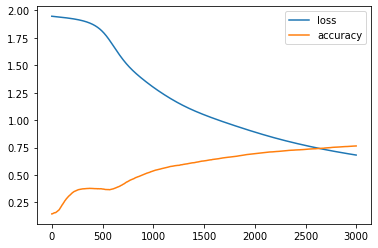

In [10]:
plt.plot(running_loss, label = 'loss')
plt.plot(running_accuracy, label = 'accuracy')
plt.legend()

<b><p style ='color: blue'>Looks like our model trained fairly well on our toy dataset.</p></b>

# Let us try this on actual dataset now

In [43]:
def train_the_model(model, batch_size, learning_rate, epochs):
    """ This function will train the model, do the prediction for labels, calculate the train & test accuracy.
    
    agrs          ::::    model          -  object of myNN class
                          batch_size     -  batch size of training dataset
                          learning_rate  -  learning rate of training
                          epochs         -
                          
    returns       ::::    train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history 
                          These list contains correponding values calculated over an epoch.
    """
    total_batches = int(len(npXtrain) / batch_size)                          # total batches of training dataset in one epoch                                  
    # creating empty lists to save the history
    train_loss_history = []
    val_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []

    for e in range(epochs):

        running_train_accuracy = 0.0
        running_train_loss = 0.0

        for i in range(total_batches):
            Xtrain = npXtrain[i * batch_size : (i+1) * batch_size].T        # slicing the full training dataset into batches
            Ytrain = npYtrain[i * batch_size : (i+1) * batch_size].T

            train_outputs = model.forward(Xtrain)                           # forward pass on train batch
            train_loss = model.loss(train_outputs, Ytrain)                  # calculating the current loss on current train batch
            grads = model.backward(train_outputs, Ytrain)                   # backwad pass and gradient calculation
            model.update(grads, learning_rate)                              # updating the weights

            train_predict = np.argmax(train_outputs, axis = 0)              # getting the predicted labels for train batch
            train_gt = np.argmax(Ytrain, axis = 0)                          # getting the ground truth label from one hot encoded matrix

            running_train_accuracy += np.mean((train_predict == train_gt))  # accumulating the batch accuracy
            running_train_loss += train_loss                                # accumulating the batch loss

        val_outputs = model.forward(Xval)                                   # forward pass on validation set
        val_loss = model.loss(val_outputs, Yval)                            # loss calculating on validation set

        val_predict = np.argmax(val_outputs, axis = 0)                      # getting the predicted labels for validation set
        val_gt = np.argmax(Yval, axis = 0)                                   # getting the ground truth labels from one hot encoded matrix

        epoch_val_accuracy = np.mean((val_predict == val_gt)) * 100         # calculating the val accuracy
        epoch_train_accuracy = 100 * (running_train_accuracy / total_batches)    # calculating the train accuracy for epoch
        epoch_train_loss = running_train_loss / total_batches               # calculating the train loss for epoch

        # appending correspond values to their list history
        train_loss_history.append(epoch_train_loss)
        val_loss_history.append(val_loss)
        train_accuracy_history.append(epoch_train_accuracy)
        val_accuracy_history.append(epoch_val_accuracy)
        
        #printing out out stats
        if e % 75 == 0:
            print("======================================================")
            print("Epoch : {}".format(e+1))
            print("Train Loss     : {:.3f},   Validation Loss     : {:.3f}".format(epoch_train_loss, val_loss))
            print("Train Accuracy : {:.3f}%,  Valdiation Accuracy : {:.3f}%".format(epoch_train_accuracy, epoch_val_accuracy))
            
    print("===========================TRAINING COMPLETE ==================================")
    test_outputs = model.forward(Xtest)                                 # forward pass on test set
    test_loss = model.loss(test_outputs, Ytest)                         # loss calculating on test set
    test_predict = np.argmax(test_outputs, axis = 0)                    # getting the predicted labels for test set
    test_gt = np.argmax(Ytest, axis = 0)                                # getting the ground truth labels from one hot encoded matrix

    epoch_test_accuracy = np.mean((test_predict == test_gt)) * 100      # calculating the test accuracy
    print("Test Loss : {:.3f} and Test Accuracy : {:.3f}%  ".format(test_loss,epoch_test_accuracy))
    
    return train_loss_history, val_loss_history, val_accuracy_history, val_accuracy_history

In [44]:
def plots(train_loss, val_loss, train_acc, val_acc):
    """This functions just draw the loss and accuracy plots obtained after training the model
    
    args ::::  train_loss  -   train_loss_history
               val_loss   -   val_loss_history
               train_acc   -   train_accuracy_history
               val_acc    -   val_accuracy_history
    """

    fig = plt.figure(figsize = (20, 6))

    ax = fig.add_subplot(1, 2, 1)
    plt.plot(train_loss, label = 'Train Loss')
    plt.plot(val_loss, label = 'Validation Loss')
    plt.title('Loss Plots')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    ax = fig.add_subplot(1, 2, 2)
    plt.plot(train_acc, label = 'Train Accuracy')
    plt.plot(val_acc, label = 'Validation Accuracy')
    plt.title("Accuracy Plots")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy in percent(%)")
    plt.legend()

In [45]:
# data reading should be in this format for proper fucntioning of train_test_prep function
# For out neural network we will use only hog features(shoud be in data folder in same directory).

"""    binary class pixel value ==>   binary_test.csv          binary_train.csv
       five class values        ==>   five_class_test.csv      five_class_train.csv
       
       hog binary features      ==>   bin_hog_test.csv         bin_hog_train.csv
       hog five class features  ==>   five_hog_train.csv       five_hog_test.csv
"""
train_data_binary = pd.read_csv('./data/bin_hog_train.csv')
test_data_binary = pd.read_csv('./data/bin_hog_test.csv')

train_data_five = pd.read_csv('./data/five_hog_train.csv')
test_data_five = pd.read_csv('./data/five_hog_test.csv')

ft_dim = train_data_binary.shape[1] - 1  #feature dimesions (used in the 'train_test_prep' funtion)

In [54]:
def train_test_prep(classes):
    
    """ Give number of classed return data for training the model
    
    args    ::::   classses  - number of classes ( 2 or 5)
    
    returns ::::   npXtrain  - numpy array containing 'X' of train set()
                   npYtrain  - numpy array containing 'y' of train set()
                   Xtest     - numpy array containing 'X' of test set()
                   Ytest     - numpy array containing 'y' of test set()
    """
    
    # supplying the proper dataframes for given classes value and getting respective numpy matrix
    if classes == 5:
        nptrain = np.array(train_data_five)
        nptest = np.array(test_data_five)
        
    if classes == 2:
        nptrain = np.array(train_data_binary)
        nptest = np.array(test_data_binary)

    npXtrain = nptrain[:, 0:ft_dim]                        # getting the 'X' part which is all columns other than the last one
    
    # storing values for normalization later for test data
    mean = npXtrain.mean(axis = 0)
    std =  npXtrain.std(axis = 0)

    npXtrain = (npXtrain - mean) / std                     # normlization of train set
    
    npYtrain = nptrain[:, ft_dim].astype(int)              # getting the 'y' part which is the last column of each row
    npYtrain = np.eye(classes)[npYtrain]                   # getting one hot encoding wrt 'y'

    # temp variables use to split the given test data into equal half validation and test data.
    r2 = nptest.shape[0]
    r1 = int(r2/2)   
    
    # getting the 'X' and 'y' for test set
    Xtest = nptest[0:r1, 0:ft_dim]
    Ytest = nptest[0:r1, ft_dim].astype(int)
    
    Ytest = np.eye(classes)[:, Ytest]                      # one hot encoding of 'Ytest'
    Xtest = (Xtest - mean) / std                           # normalization of test set
    Xtest = Xtest.T                                        # getting it in appropriate shape
    
    
    # getting the 'X' and 'y' for validation set
    Xval = nptest[r1: r2, 0:ft_dim]
    Yval = nptest[r1: r2, ft_dim].astype(int)
    
    Yval = np.eye(classes)[:, Yval]                      # one hot encoding of 'Ytest'
    Xval = (Xval - mean) / std                           # normalization of test set
    Xval = Xval.T                                        # getting it in appropriate shape

    
    # printing our the shapes for cross checking purpose
    print("trainX ka shape ", npXtrain.shape)
    print("trainY ka shape ", npYtrain.shape)
    
    print("Xtest ka shape ", Xtest.shape)
    print("Ytest ka shape ", Ytest.shape)
    
    print("Xval ka shape ", Xval.shape)
    print("Yval ka shape ", Yval.shape)

    
    return npXtrain, npYtrain, Xtest, Ytest, Xval, Yval

<h1>Training the model for binary class classification</h1>
<p> We have tried multiple FCN architechtures with various hyperparameters. Here are few of the best performing ones. </p>

<h2 style = 'color : Blue'> Architechture 1 </h2>

trainX ka shape  (9938, 144)
trainY ka shape  (9938, 2)
Xtest ka shape  (144, 1000)
Ytest ka shape  (2, 1000)
Xval ka shape  (144, 1000)
Yval ka shape  (2, 1000)
Epoch : 1
Train Loss     : 0.677,   Validation Loss     : 0.680
Train Accuracy : 57.268%,  Valdiation Accuracy : 56.800%
Epoch : 76
Train Loss     : 0.406,   Validation Loss     : 0.428
Train Accuracy : 82.550%,  Valdiation Accuracy : 81.700%
Epoch : 151
Train Loss     : 0.332,   Validation Loss     : 0.362
Train Accuracy : 86.048%,  Valdiation Accuracy : 84.800%
Epoch : 226
Train Loss     : 0.297,   Validation Loss     : 0.335
Train Accuracy : 87.550%,  Valdiation Accuracy : 85.000%
Epoch : 301
Train Loss     : 0.273,   Validation Loss     : 0.320
Train Accuracy : 88.841%,  Valdiation Accuracy : 86.100%
Epoch : 376
Train Loss     : 0.254,   Validation Loss     : 0.310
Train Accuracy : 89.647%,  Valdiation Accuracy : 86.100%
Epoch : 451
Train Loss     : 0.236,   Validation Loss     : 0.302
Train Accuracy : 90.262%,  Valdiation

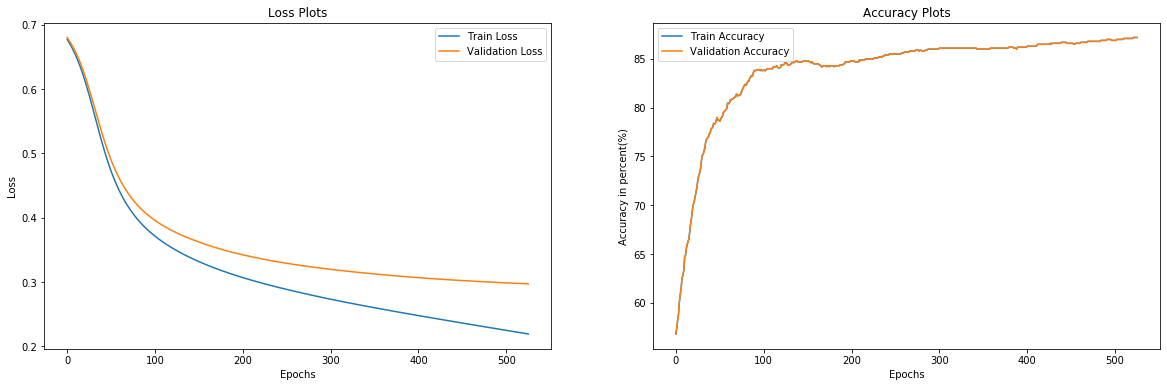

In [47]:
CLASS = 2                                                          # Number of classes(2 or 5)

BATCH_SIZE = 64
LEARNING_RATE = 0.0005
EPOCH = 526
npXtrain, npYtrain, Xtest, Ytest, Xval, Yval = train_test_prep(CLASS)          # Getting the data

in_ft = Xtest.shape[0]                                             # dimensions of input features
model = myNN([in_ft,65, 20 , CLASS])                           # defining model architechture


# training the model
train_loss, val_loss, train_acc, val_acc = train_the_model(model, BATCH_SIZE, LEARNING_RATE, EPOCH)
plots(train_loss, val_loss, train_acc, val_acc)

<style>
table {
  width:100%;
}
table, th, td {
  border: 1px solid black;
  border-collapse: collapse;
}
th, td {
  padding: 15px;
  text-align: left;
}
table tr:nth-child(even) {
  background-color: #eee;
}
table tr:nth-child(odd) {
 background-color: #fff;
}
table th {
  background-color: black;
  color: white;
}
</style>

<h1>Results :</h1>

<table>
  <tr>
      <td><b>Learnable Parameters</b></td>
    <td>10787</td>
  </tr>
  <tr>
    <td><b>Train Accuracy </b></td>
    <td>90.998%</td>
  </tr>
      <tr>
    <td><b>Validation Accuracy</b></td>
    <td>87.200%</td>
  </tr>
  <tr>
    <td><b>Test Accuracy</b></td>
    <td>88.400%</td>
  </tr>
    <tr>
    <td><b>Batch Size</b></td>
    <td>64</td>
  </tr>
    <tr>
    <td><b>Epochs</b></td>
    <td>526</td>
  </tr>
    <tr>
    <td><b>Optimizer</b></td>
    <td>SGD</td>
  </tr>
    <tr>
    <td><b>Learning Rate</b></td>
    <td>0.0005</td>
  </tr>
</table>

<h2 style = 'color : Blue'> Architechture 2 </h2>

trainX ka shape  (9938, 144)
trainY ka shape  (9938, 2)
Xtest ka shape  (144, 1000)
Ytest ka shape  (2, 1000)
Xval ka shape  (144, 1000)
Yval ka shape  (2, 1000)
Epoch : 1
Train Loss     : 0.691,   Validation Loss     : 0.691
Train Accuracy : 53.065%,  Valdiation Accuracy : 53.500%
Epoch : 76
Train Loss     : 0.332,   Validation Loss     : 0.354
Train Accuracy : 86.069%,  Valdiation Accuracy : 85.800%
Epoch : 151
Train Loss     : 0.265,   Validation Loss     : 0.316
Train Accuracy : 89.163%,  Valdiation Accuracy : 86.300%
Epoch : 226
Train Loss     : 0.218,   Validation Loss     : 0.297
Train Accuracy : 91.512%,  Valdiation Accuracy : 87.500%
Epoch : 301
Train Loss     : 0.174,   Validation Loss     : 0.294
Train Accuracy : 93.337%,  Valdiation Accuracy : 88.300%
===========================TRAINING COMPLETE ==================================
Test Loss : 0.300 and Test Accuracy : 88.900%  


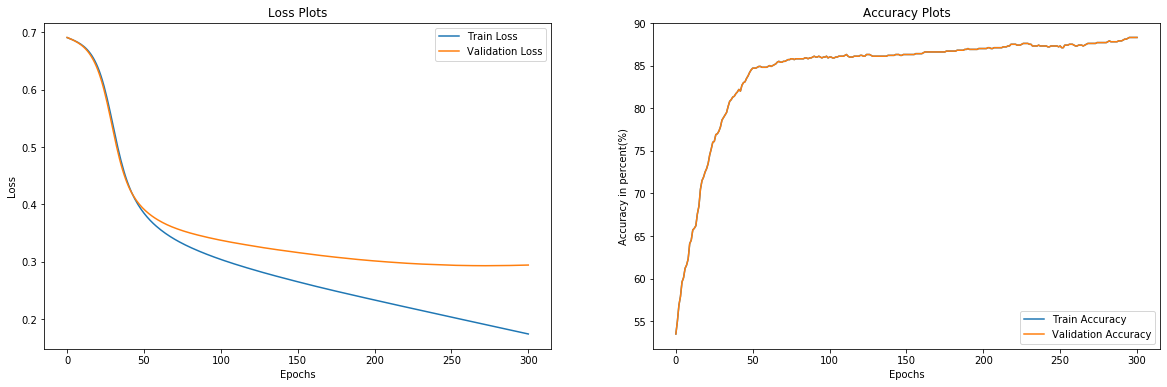

In [48]:
CLASS = 2                                                          # Number of classes(2 or 5)

BATCH_SIZE = 32
LEARNING_RATE = 0.0005
EPOCH = 301
npXtrain, npYtrain, Xtest, Ytest, Xval, Yval = train_test_prep(CLASS)          # Getting the data

in_ft = Xtest.shape[0]                                             # dimensions of input features
model = myNN([in_ft,85,35, 20 , CLASS])                           # defining model architechture


# training the model
train_loss, test_loss, train_acc, test_acc = train_the_model(model, BATCH_SIZE, LEARNING_RATE, EPOCH)
plots(train_loss, test_loss, train_acc, test_acc)

<style>
table {
  width:100%;
}
table, th, td {
  border: 1px solid black;
  border-collapse: collapse;
}
th, td {
  padding: 15px;
  text-align: left;
}
table tr:nth-child(even) {
  background-color: #eee;
}
table tr:nth-child(odd) {
 background-color: #fff;
}
table th {
  background-color: black;
  color: white;
}
</style>

<h1>Results :</h1>

<table>
  <tr>
      <td><b>Learnable Parameters</b></td>
    <td>16097</td>
  </tr>
  <tr>
    <td><b>Train Accuracy </b></td>
    <td>93.337%</td>
  </tr>
  <tr>
    <td><b>Validation Accuracy</b></td>
    <td>88.30%</td>
  </tr>
  <tr>
    <td><b>Test Accuracy</b></td>
    <td>88.90%</td>
  </tr>
    <tr>
    <td><b>Batch Size</b></td>
    <td>32</td>
  </tr>
    <tr>
    <td><b>Epochs</b></td>
    <td>301</td>
  </tr>
    <tr>
    <td><b>Optimizer</b></td>
    <td>SGD</td>
  </tr>
    <tr>
    <td><b>Learning Rate</b></td>
    <td>0.0005</td>
  </tr>
</table>

<h2 style = 'color : Blue'> Architechture 3 </h2>

trainX ka shape  (9938, 144)
trainY ka shape  (9938, 2)
Xtest ka shape  (144, 1000)
Ytest ka shape  (2, 1000)
Xval ka shape  (144, 1000)
Yval ka shape  (2, 1000)
Epoch : 1
Train Loss     : 0.692,   Validation Loss     : 0.688
Train Accuracy : 50.152%,  Valdiation Accuracy : 50.500%
Epoch : 76
Train Loss     : 0.485,   Validation Loss     : 0.483
Train Accuracy : 80.804%,  Valdiation Accuracy : 79.400%
Epoch : 151
Train Loss     : 0.361,   Validation Loss     : 0.364
Train Accuracy : 84.943%,  Valdiation Accuracy : 85.100%
Epoch : 226
Train Loss     : 0.313,   Validation Loss     : 0.326
Train Accuracy : 87.185%,  Valdiation Accuracy : 86.200%
Epoch : 301
Train Loss     : 0.283,   Validation Loss     : 0.306
Train Accuracy : 88.403%,  Valdiation Accuracy : 86.600%
Epoch : 376
Train Loss     : 0.259,   Validation Loss     : 0.293
Train Accuracy : 89.418%,  Valdiation Accuracy : 87.100%
Epoch : 451
Train Loss     : 0.239,   Validation Loss     : 0.284
Train Accuracy : 90.219%,  Valdiation

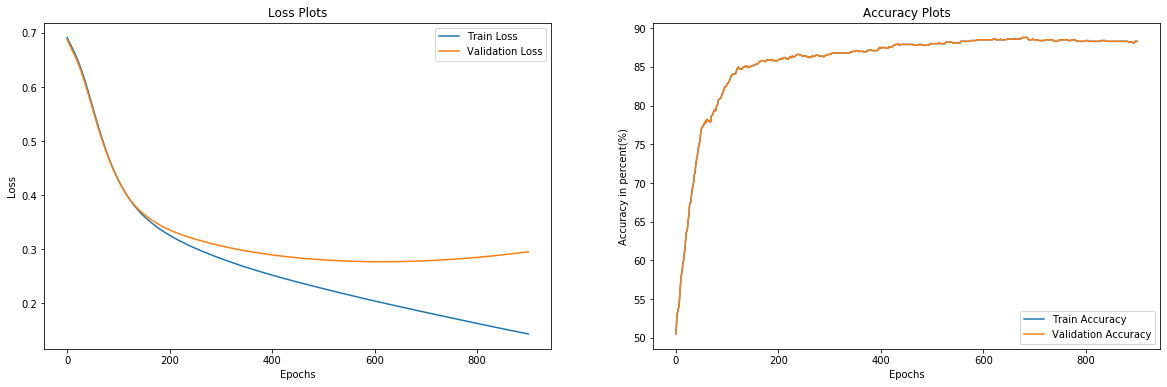

In [53]:
CLASS = 2                                                          # Number of classes(2 or 5)

BATCH_SIZE = 128
LEARNING_RATE = 0.001
EPOCH = 901
npXtrain, npYtrain, Xtest, Ytest, Xval, Yval = train_test_prep(CLASS)          # Getting the data

in_ft = Xtest.shape[0]                                             # dimensions of input features
model = myNN([in_ft,65, 10, CLASS])                           # defining model architechture


# training the model
train_loss, test_loss, train_acc, test_acc = train_the_model(model, BATCH_SIZE, LEARNING_RATE, EPOCH)
plots(train_loss, test_loss, train_acc, test_acc)

<style>
table {
  width:100%;
}
table, th, td {
  border: 1px solid black;
  border-collapse: collapse;
}
th, td {
  padding: 15px;
  text-align: left;
}
table tr:nth-child(even) {
  background-color: #eee;
}
table tr:nth-child(odd) {
 background-color: #fff;
}
table th {
  background-color: black;
  color: white;
}
</style>

<h1>Results :</h1>

<table>
  <tr>
      <td><b>Learnable Parameters</b></td>
    <td>10107</td>
  </tr>
  <tr>
    <td><b>Train Accuracy </b></td>
    <td>95.434%</td>
  </tr>
  <tr>
  <tr>
    <td><b>Validation Accuracy </b></td>
    <td>88.30%</td>
  </tr>
  <tr>
    <td><b>Test Accuracy</b></td>
    <td>88.00%</td>
  </tr>
    <tr>
    <td><b>Batch Size</b></td>
    <td>128</td>
  </tr>
    <tr>
    <td><b>Epochs</b></td>
    <td>901</td>
  </tr>
    <tr>
    <td><b>Optimizer</b></td>
    <td>SGD</td>
  </tr>
    <tr>
    <td><b>Learning Rate</b></td>
    <td>0.001</td>
  </tr>
</table>

<h1>Training the model for Five class classification</h1>
<p> We have tried multiple FCN architechtures with various hyperparameters. Here are few of the best performing ones. </p>

<h2 style = 'color : Blue'> Architechture 1 </h2>

trainX ka shape  (24994, 144)
trainY ka shape  (24994, 5)
Xtest ka shape  (144, 2500)
Ytest ka shape  (5, 2500)
Xval ka shape  (144, 2500)
Yval ka shape  (5, 2500)
Epoch : 1
Train Loss     : 1.613,   Validation Loss     : 1.608
Train Accuracy : 19.331%,  Valdiation Accuracy : 20.120%
Epoch : 76
Train Loss     : 1.173,   Validation Loss     : 1.182
Train Accuracy : 51.254%,  Valdiation Accuracy : 49.800%
Epoch : 151
Train Loss     : 1.038,   Validation Loss     : 1.069
Train Accuracy : 58.866%,  Valdiation Accuracy : 56.880%
Epoch : 226
Train Loss     : 0.964,   Validation Loss     : 1.017
Train Accuracy : 62.067%,  Valdiation Accuracy : 59.560%
Epoch : 301
Train Loss     : 0.911,   Validation Loss     : 0.990
Train Accuracy : 64.227%,  Valdiation Accuracy : 60.680%
Epoch : 376
Train Loss     : 0.866,   Validation Loss     : 0.975
Train Accuracy : 66.390%,  Valdiation Accuracy : 61.360%
Epoch : 451
Train Loss     : 0.824,   Validation Loss     : 0.968
Train Accuracy : 68.466%,  Valdiati

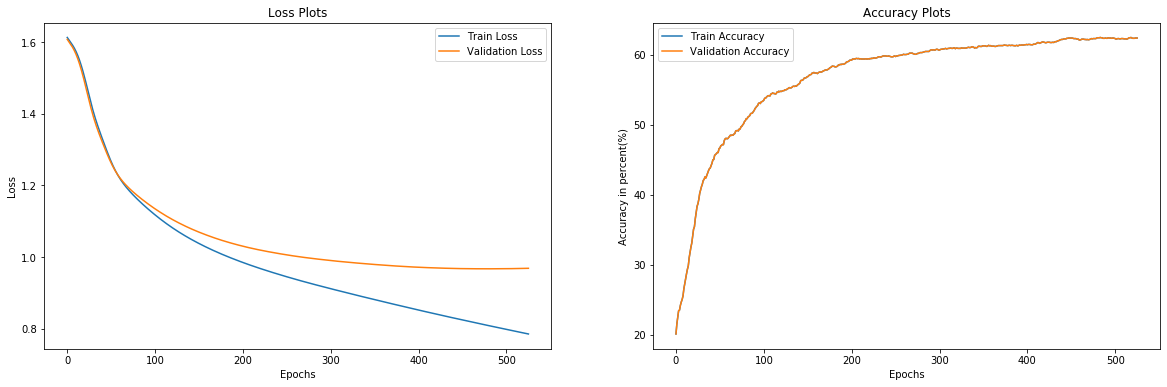

In [57]:
CLASS = 5                                                          # Number of classes(2 or 5)

BATCH_SIZE = 128
LEARNING_RATE = 0.001
EPOCH = 526
npXtrain, npYtrain, Xtest, Ytest, Xval, Yval = train_test_prep(CLASS)          # Getting the data

in_ft = Xtest.shape[0]                                             # dimensions of input features
model = myNN([in_ft,85, 65, 20, CLASS])                           # defining model architechture


# training the model
train_loss, test_loss, train_acc, test_acc = train_the_model(model, BATCH_SIZE, LEARNING_RATE, EPOCH)
plots(train_loss, test_loss, train_acc, test_acc)

<style>
table {
  width:100%;
}
table, th, td {
  border: 1px solid black;
  border-collapse: collapse;
}
th, td {
  padding: 15px;
  text-align: left;
}
table tr:nth-child(even) {
  background-color: #eee;
}
table tr:nth-child(odd) {
 background-color: #fff;
}
table th {
  background-color: black;
  color: white;
}
</style>

<h1>Results :</h1>

<table>
  <tr>
      <td><b>Learnable Parameters</b></td>
    <td>19340</td>
  </tr>
  <tr>
    <td><b>Train Accuracy </b></td>
    <td>70.441%</td>
  </tr>
  <tr>
    <td><b>Train Accuracy </b></td>
    <td>62.400%</td>
  </tr>
  <tr>
    <td><b>Test Accuracy</b></td>
    <td>62.600%</td>
  </tr>
    <tr>
    <td><b>Batch Size</b></td>
    <td>128</td>
  </tr>
    <tr>
    <td><b>Epochs</b></td>
    <td>526</td>
  </tr>
    <tr>
    <td><b>Optimizer</b></td>
    <td>SGD</td>
  </tr>
    <tr>
    <td><b>Learning Rate</b></td>
    <td>0.001</td>
  </tr>
</table>

<h2 style = 'color : Blue'> Architechture 2 </h2>

trainX ka shape  (24994, 144)
trainY ka shape  (24994, 5)
Xtest ka shape  (144, 2500)
Ytest ka shape  (5, 2500)
Xval ka shape  (144, 2500)
Yval ka shape  (5, 2500)
Epoch : 1
Train Loss     : 1.601,   Validation Loss     : 1.596
Train Accuracy : 23.345%,  Valdiation Accuracy : 24.880%
Epoch : 76
Train Loss     : 1.159,   Validation Loss     : 1.158
Train Accuracy : 52.316%,  Valdiation Accuracy : 53.080%
Epoch : 151
Train Loss     : 1.038,   Validation Loss     : 1.057
Train Accuracy : 58.349%,  Valdiation Accuracy : 57.920%
Epoch : 226
Train Loss     : 0.975,   Validation Loss     : 1.019
Train Accuracy : 61.146%,  Valdiation Accuracy : 59.640%
Epoch : 301
Train Loss     : 0.928,   Validation Loss     : 0.996
Train Accuracy : 63.213%,  Valdiation Accuracy : 60.480%
Epoch : 376
Train Loss     : 0.892,   Validation Loss     : 0.982
Train Accuracy : 64.904%,  Valdiation Accuracy : 61.280%
Epoch : 451
Train Loss     : 0.860,   Validation Loss     : 0.973
Train Accuracy : 66.446%,  Valdiati

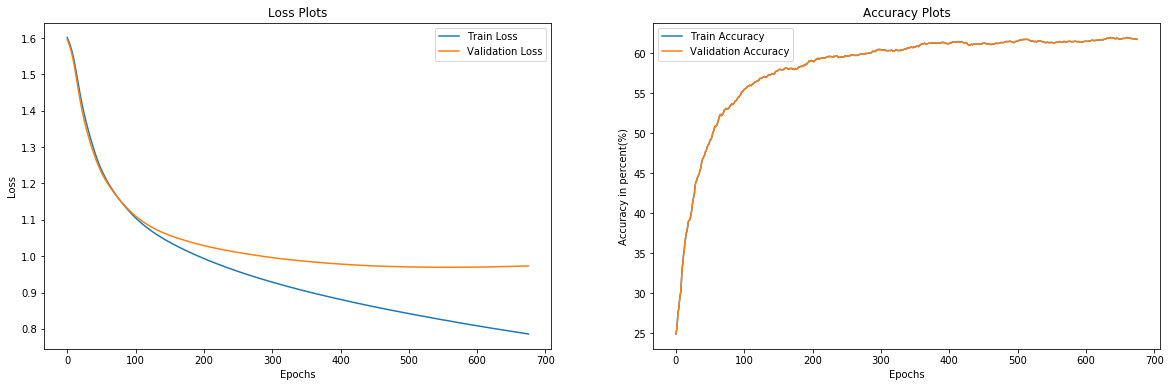

In [58]:
CLASS = 5                                                          # Number of classes(2 or 5)

BATCH_SIZE = 128
LEARNING_RATE = 0.001
EPOCH = 676
npXtrain, npYtrain, Xtest, Ytest, Xval, Yval = train_test_prep(CLASS)          # Getting the data

in_ft = Xtest.shape[0]                                             # dimensions of input features
model = myNN([in_ft, 65, 12, CLASS])                           # defining model architechture


# training the model
train_loss, test_loss, train_acc, test_acc = train_the_model(model, BATCH_SIZE, LEARNING_RATE, EPOCH)
plots(train_loss, test_loss, train_acc, test_acc)

<style>
table {
  width:100%;
}
table, th, td {
  border: 1px solid black;
  border-collapse: collapse;
}
th, td {
  padding: 15px;
  text-align: left;
}
table tr:nth-child(even) {
  background-color: #eee;
}
table tr:nth-child(odd) {
 background-color: #fff;
}
table th {
  background-color: black;
  color: white;
}
</style>

<h1>Results :</h1>

<table>
  <tr>
      <td><b>Learnable Parameters</b></td>
    <td>19340</td>
  </tr>
  <tr>
    <td><b>Train Accuracy </b></td>
    <td>69.643%</td>
  </tr>
  <tr>
    <td><b>Validation Accuracy</b></td>
    <td>61.760%</td>
  </tr>
  <tr>
    <td><b>Test Accuracy</b></td>
    <td>63.760%</td>
  </tr>
    <tr>
    <td><b>Batch Size</b></td>
    <td>128</td>
  </tr>
    <tr>
    <td><b>Epochs</b></td>
    <td>676</td>
  </tr>
    <tr>
    <td><b>Optimizer</b></td>
    <td>SGD</td>
  </tr>
    <tr>
    <td><b>Learning Rate</b></td>
    <td>0.001</td>
  </tr>
</table>

<h1>Conclusions :</h1>
<ul>
    <li><h3> Binary Classification </h3></li>
    <p style = 'color:blue'> Best model achived accuracy of <b>88.30%</b> on test set and <b>88.90%</b> on validation(unseen) set with <b>10107</b> trainable parameters.
    </p>
    <li><h3> Five Class Classification</h3></li>
    <p style = 'color:blue'> Best model achived accuracy of <b>62.40%</b> on test set and <b>63.760%</b> validation set(unseen set) with <b>10282</b> trainable parameters.
    </p>
</ul>

<p style = 'color:red'><b>Disclaimer : </b>results may slightly vary in all training instances due to random initialization of weights. </p>